# 451 Financial Engineering: Programming Assignment 2
**Eli Freedman**

**October 19, 2025**

## Overview

This assignment investigates simulating returns for varying assets using either only long positions, or long and short positions. The simulation is performed on two different sets of assets. The first set, denoted as `set_1` throughout the notebook, is dummy data collected from the jumpstart code provided by Professor Miller. The second set, `set_2`, is made up of four equities: Procter & Gamble (`$PG`), Coca-Cola (`$KO`), PepsiCo (`$PEP`), and Costco (`$COST`). These equities were used specifically because they are used for my final project consumer staples ETF.

Notes:
- Mean Returns and Volatility for `asset_set_2` are captured from the annual average over the last 20 years

References:
- https://www.financecharts.com/stocks/PG/performance/total-return-cagr
- https://www.financecharts.com/stocks/KO/performance/total-return-cagr
- https://www.financecharts.com/stocks/PEP/performance/total-return-cagr
- https://www.financecharts.com/stocks/COST/performance/total-return-cagr
- https://www.finance.yahoo.com

## Imports

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.backends.backend_pdf import PdfPages

## Set Variables and Functions

In [2]:
# Set variables for tickers and date range
tickers = ['PG', 'KO', 'PEP', 'COST']
start_date = '2005-01-01'
end_date = '2025-01-01'

# Number of Monte Carlo simulations
sample_size = 700

# Set random seed for reproducibility
rng = np.random.default_rng(seed=56)

# Generate random seed for weight generation
rng_weight_seed = np.random.default_rng(seed=16)

In [3]:
def make_weights(shorts_ok, rng):
    if shorts_ok:
        three = rng.uniform(-1, 1, size=3)
        fourth = 1 - three.sum()
        return np.concatenate([three, [fourth]])
    else:
        w = rng.uniform(0, 1, size=4)
        return w / w.sum()

In [4]:
def portfolio_stats(weights_matrix, returns, data_cov):
    results = []
    for w in weights_matrix:
        positions = 1  # has shorts
        if np.all(w > 0):
            positions = 2
        # portfolio returns time series = returns @ w
        ret_series = returns @ w
        return_mean = ret_series.mean()
        return_sd = np.sqrt(w.T @ data_cov @ w)
        results.append({
            'w1': w[0], 'w2': w[1], 'w3': w[2], 'w4': w[3],
            'Positions': positions, 'returnMean': return_mean, 'returnSD': return_sd
        })
    return pd.DataFrame(results)

## Initial Conditions

### Mean Annual Returns

In [5]:
# These are the dummy assets from the jumpstart code
mean_returns_set_1 = np.array([
    0.02, # Asset A
    0.07, # Asset B
    0.15, # Asset C
    0.20  # Asset D
])

# These are four assets from the final project
mean_returns_set_2 = np.array([
    0.0803, # $PG
    0.0927, # $KO
    0.0801, # $PEP
    0.1942  # $COST
])

### Volatility of Annual Returns

I was not able to find the 20-year volatility of these assets online, so I calculated it myself.

In [6]:
volatilities = {}

for symbol in tickers:
    ticker = yf.Ticker(symbol)
    data = ticker.history(start=start_date, end=end_date, auto_adjust=True)
    if data.empty:
        print(f"No data for {symbol}")
        continue
    else:
        print(f"Fetched data for {symbol}")
        print("Saving to CSV...")
        data.to_csv(f"{symbol}_historical_data.csv")

    # Use Adjusted Close prices
    data['log_return'] = np.log(data['Close'] / data['Close'].shift(1))
    
    # Compute daily standard deviation of log returns
    sigma_d = data['log_return'].std(ddof=1)
    
    # Annualize volatility
    sigma_ann = sigma_d * np.sqrt(252)
    
    volatilities[symbol] = sigma_ann

vol_df = pd.DataFrame.from_dict(volatilities, orient='index', columns=['Annualized Volatility'])
print("\n", vol_df)

Fetched data for PG
Saving to CSV...
Fetched data for KO
Saving to CSV...
Fetched data for PEP
Saving to CSV...
Fetched data for COST
Saving to CSV...

       Annualized Volatility
PG                 0.180402
KO                 0.181312
PEP                0.179856
COST               0.224072


In [7]:
# These are the dummy assets from the jumpstart code
sd_returns_set_1 = np.array([
    0.05, # Asset A
    0.12, # Asset B
    0.17, # Asset C
    0.25  # Asset D
])

# These are four assets from the final project
sd_returns_set_2 = np.array([
    0.180402, # $PG
    0.181312, # $KO
    0.179856, # $PEP
    0.224072  # $COST
])

### Asset Correlation

In [8]:
# Fetch historical adjusted close prices for each ticker
price_data = pd.DataFrame()
for t in tickers:
    ticker = yf.Ticker(t)
    hist = ticker.history(start=start_date, end=end_date, auto_adjust=True)['Close']
    hist.name = t
    price_data = pd.concat([price_data, hist], axis=1)

# Ensure the index is a DatetimeIndex
price_data.index = pd.to_datetime(price_data.index)

# Compute annual log returns
annual_prices = price_data.resample('YE').ffill()  # Resample by year
annual_returns = np.log(annual_prices / annual_prices.shift(1)).dropna()

# Annualized volatility (std of returns)
annual_vol = annual_returns.std() * np.sqrt(252)

# Covariance matrix
cov_matrix = annual_returns.cov()

# Correlation matrix
corr_matrix = annual_returns.corr()

print("\nCovariance Matrix:")
print(cov_matrix)
print("\nCorrelation Matrix:")
print(corr_matrix)



Covariance Matrix:
            PG        KO       PEP      COST
PG    0.013053  0.007836  0.009981  0.013383
KO    0.007836  0.014922  0.012216  0.009342
PEP   0.009981  0.012216  0.016369  0.012092
COST  0.013383  0.009342  0.012092  0.033627

Correlation Matrix:
            PG        KO       PEP      COST
PG    1.000000  0.561462  0.682807  0.638789
KO    0.561462  1.000000  0.781619  0.417024
PEP   0.682807  0.781619  1.000000  0.515382
COST  0.638789  0.417024  0.515382  1.000000


In [9]:
# These are the dummy assets from the jumpstart code
corr_matrix_set_1 = np.array([
    [1.0, 0.3, 0.3, 0.3],
    [0.3, 1.0, 0.6, 0.6],
    [0.3, 0.6, 1.0, 0.6],
    [0.3, 0.6, 0.6, 1.0]
])

# These are four assets from the final project
corr_matrix_set_2 = np.array([
    [1.000000, 0.541451, 0.702363, 0.658261],
    [0.541451, 1.000000, 0.764840, 0.411341],
    [0.702363, 0.764840, 1.000000, 0.538116],
    [0.658261, 0.411341, 0.538116, 1.000000]
])

### Asset Covariance

In [10]:
# These are the dummy assets from the jumpstart code
cov_matrix_set_1 = np.diag(sd_returns_set_1) @ corr_matrix_set_1 @ np.diag(sd_returns_set_1)

# These are four assets from the final project
cov_matrix_set_2 = np.diag(sd_returns_set_2) @ corr_matrix_set_2 @ np.diag(sd_returns_set_2)

## Generate Multivariate Normal Returns

In [11]:
set_1_returns = rng.multivariate_normal(
    mean=mean_returns_set_1,
    cov=cov_matrix_set_1,
    size=sample_size
)

set_2_returns = rng.multivariate_normal(
    mean=mean_returns_set_2,
    cov=cov_matrix_set_2,
    size=sample_size
)

In [12]:
set_1_returns_df = pd.DataFrame(set_1_returns, columns=['Asset A', 'Asset B', 'Asset C', 'Asset D'])

set_2_returns_df = pd.DataFrame(set_2_returns, columns=tickers)

In [13]:
set_1_returns_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Asset A,700.0,0.018545,0.050081,-0.129666,-0.014498,0.017150,0.050914,0.174928
Asset B,700.0,0.059293,0.123838,-0.339751,-0.019557,0.053695,0.143892,0.440008
Asset C,700.0,0.150622,0.171161,-0.381248,0.042682,0.150592,0.263329,0.742309
Asset D,700.0,0.192199,0.258879,-0.577995,0.023269,0.198909,0.360243,0.965651


In [14]:
set_2_returns_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PG,700.0,0.078142,0.185140,-0.457300,-0.045537,0.073792,0.214033,0.564758
KO,700.0,0.095131,0.172812,-0.462481,-0.013269,0.098898,0.208753,0.571050
PEP,700.0,0.085292,0.179036,-0.448244,-0.031140,0.090667,0.207983,0.547425
COST,700.0,0.191791,0.226062,-0.501604,0.041494,0.202649,0.349691,1.007241


## Compare Correlations and Covariances

In [15]:
cov_matrix_set_1_actual = set_1_returns_df.cov().values

print(
f"""
Target Correlation Matrix Set 1:
{corr_matrix_set_1}

Actual Correlation Matrix Set 1:
{set_1_returns_df.corr().values}

Target Covariance Matrix Set 1:
{cov_matrix_set_1}

Actual Covariance Matrix Set 1:
{cov_matrix_set_1_actual}
"""
)



Target Correlation Matrix Set 1:
[[1.  0.3 0.3 0.3]
 [0.3 1.  0.6 0.6]
 [0.3 0.6 1.  0.6]
 [0.3 0.6 0.6 1. ]]

Actual Correlation Matrix Set 1:
[[1.         0.32493344 0.32137954 0.31708109]
 [0.32493344 1.         0.59439404 0.61270397]
 [0.32137954 0.59439404 1.         0.61720412]
 [0.31708109 0.61270397 0.61720412 1.        ]]

Target Covariance Matrix Set 1:
[[0.0025  0.0018  0.00255 0.00375]
 [0.0018  0.0144  0.01224 0.018  ]
 [0.00255 0.01224 0.0289  0.0255 ]
 [0.00375 0.018   0.0255  0.0625 ]]

Actual Covariance Matrix Set 1:
[[0.00250812 0.00201523 0.00275485 0.00411093]
 [0.00201523 0.01533596 0.01259898 0.01964275]
 [0.00275485 0.01259898 0.02929617 0.0273483 ]
 [0.00411093 0.01964275 0.0273483  0.06701811]]



In [16]:
cov_matrix_set_2_actual = set_2_returns_df.cov().values

print(
f"""
Target Correlation Matrix Set 2:
{corr_matrix_set_2}

Actual Correlation Matrix Set 2:
{set_2_returns_df.corr().values}

Target Covariance Matrix Set 2:
{cov_matrix_set_2}

Actual Covariance Matrix Set 2:
{cov_matrix_set_2_actual}
"""
)


Target Correlation Matrix Set 2:
[[1.       0.541451 0.702363 0.658261]
 [0.541451 1.       0.76484  0.411341]
 [0.702363 0.76484  1.       0.538116]
 [0.658261 0.411341 0.538116 1.      ]]

Actual Correlation Matrix Set 2:
[[1.         0.57564413 0.70140938 0.6895779 ]
 [0.57564413 1.         0.77003398 0.45013165]
 [0.70140938 0.77003398 1.         0.55028456]
 [0.6895779  0.45013165 0.55028456 1.        ]]

Target Covariance Matrix Set 2:
[[0.03254488 0.01771035 0.02278914 0.02660891]
 [0.01771035 0.03287404 0.02494147 0.01671153]
 [0.02278914 0.02494147 0.03234818 0.02168645]
 [0.02660891 0.01671153 0.02168645 0.05020826]]

Actual Covariance Matrix Set 2:
[[0.03427694 0.01841739 0.02324952 0.02886099]
 [0.01841739 0.02986386 0.02382453 0.01758488]
 [0.02324952 0.02382453 0.03205405 0.02227181]
 [0.02886099 0.01758488 0.02227181 0.05110385]]



## Generate Returns

In [17]:
weights_matrix_shorts_allowed_set_1 = np.array([make_weights(True, rng_weight_seed) for _ in range(sample_size)])
weights_matrix_no_shorts_allowed_set_1 = np.array([make_weights(False, rng_weight_seed) for _ in range(sample_size)])

shorts_allowed_results_set_1 = portfolio_stats(weights_matrix_shorts_allowed_set_1, set_1_returns, cov_matrix_set_1_actual)
shorts_allowed_results_set_1['InvestmentType'] = 'Shorts OK'

no_shorts_results_set_1 = portfolio_stats(weights_matrix_no_shorts_allowed_set_1, set_1_returns, cov_matrix_set_1_actual)
no_shorts_results_set_1['InvestmentType'] = 'Long Positions Only'

In [18]:
print("Shorts Allowed Results Set 1:")
shorts_allowed_results_set_1.head()

Shorts Allowed Results Set 1:


,w1,w2,w3,w4,Positions,returnMean,returnSD,InvestmentType
0,0.133834,-0.138512,-0.811852,1.816530,1,0.221122,0.392943,Shorts OK
1,-0.303841,0.243018,-0.956690,2.017513,1,0.252440,0.452585,Shorts OK
2,0.749265,0.708099,-0.911392,0.454028,1,0.005868,0.148847,Shorts OK
3,0.604842,-0.630410,0.391248,0.634320,1,0.154684,0.181752,Shorts OK
4,-0.689999,0.383240,0.917268,0.389492,1,0.222948,0.256444,Shorts OK


In [19]:
print("No Shorts Results Set 1:")
no_shorts_results_set_1.head()

No Shorts Results Set 1:


,w1,w2,w3,w4,Positions,returnMean,returnSD,InvestmentType
0,0.136598,0.341589,0.113277,0.408535,2,0.118369,0.152047,Long Positions Only
1,0.251601,0.406348,0.106374,0.235678,2,0.090079,0.118384,Long Positions Only
2,0.142193,0.302713,0.298061,0.257033,2,0.114882,0.136801,Long Positions Only
3,0.197247,0.254755,0.159803,0.388194,2,0.117444,0.145774,Long Positions Only
4,0.302853,0.294801,0.190599,0.211746,2,0.092502,0.113634,Long Positions Only


In [20]:
weights_matrix_shorts_allowed_set_2 = np.array([make_weights(True, rng_weight_seed) for _ in range(sample_size)])
weights_matrix_no_shorts_allowed_set_2 = np.array([make_weights(False, rng_weight_seed) for _ in range(sample_size)])

shorts_allowed_results_set_2 = portfolio_stats(weights_matrix_shorts_allowed_set_2, set_2_returns, cov_matrix_set_2_actual)
shorts_allowed_results_set_2['InvestmentType'] = 'Shorts OK'

no_shorts_results_set_2 = portfolio_stats(weights_matrix_no_shorts_allowed_set_2, set_2_returns, cov_matrix_set_2_actual)
no_shorts_results_set_2['InvestmentType'] = 'Long Positions Only'

In [21]:
print("Shorts Allowed Results Set 2:")
shorts_allowed_results_set_2.head()

Shorts Allowed Results Set 2:


,w1,w2,w3,w4,Positions,returnMean,returnSD,InvestmentType
0,-0.056507,-0.850464,0.373798,1.533173,1,0.240610,0.326532,Shorts OK
1,0.996010,-0.171085,0.841925,-0.666851,1,0.005469,0.216431,Shorts OK
2,0.220151,0.496598,0.890256,-0.607005,1,0.023959,0.212321,Shorts OK
3,0.114005,-0.391684,0.334734,0.942946,1,0.181046,0.234979,Shorts OK
4,-0.151543,0.930809,-0.416947,0.637681,1,0.163446,0.188993,Shorts OK


In [22]:
print("No Shorts Results Set 2:")
no_shorts_results_set_2.head()

No Shorts Results Set 2:


,w1,w2,w3,w4,Positions,returnMean,returnSD,InvestmentType
0,0.057802,0.487735,0.420612,0.033851,2,0.093283,0.161926,Long Positions Only
1,0.629464,0.029769,0.099888,0.240879,2,0.106738,0.175284,Long Positions Only
2,0.338985,0.040812,0.305676,0.314527,2,0.116767,0.169852,Long Positions Only
3,0.332068,0.004780,0.273863,0.389289,2,0.124424,0.174799,Long Positions Only
4,0.121508,0.256683,0.257227,0.364582,2,0.125777,0.164806,Long Positions Only


## Returns Visualization

Saved `Set 1` plot to monte_carlo_results_set_1.pdf


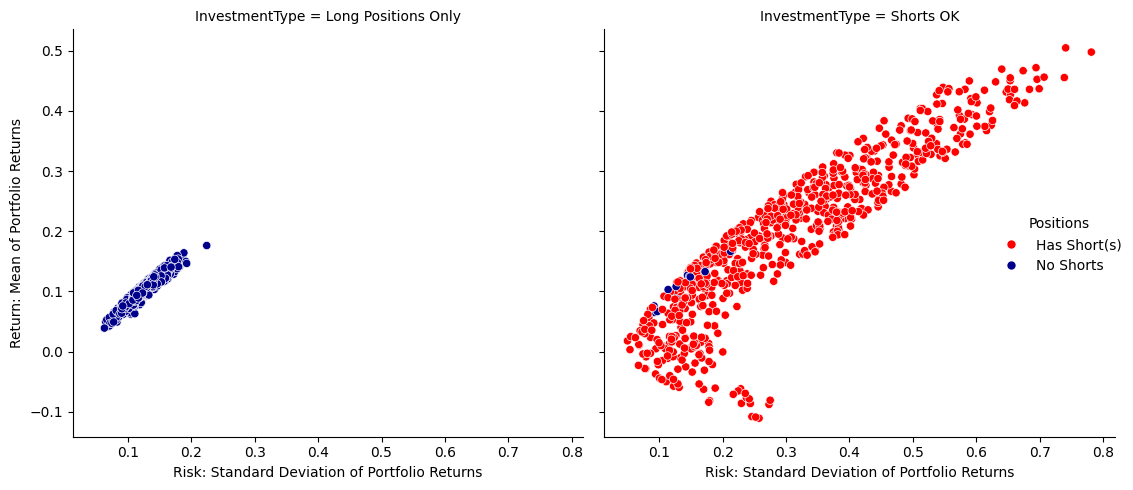

In [23]:
# Combine for plotting
plotting_frame_set_1 = pd.concat([shorts_allowed_results_set_1, no_shorts_results_set_1], ignore_index=True)
plotting_frame_set_1["Positions"] = plotting_frame_set_1["Positions"].map({1: "Has Short(s)", 2: "No Shorts"})
plotting_frame_set_1["InvestmentType"] = plotting_frame_set_1["InvestmentType"].astype("category")

set_1_plot = sns.relplot(
    data=plotting_frame_set_1,
    x="returnSD",
    y="returnMean",
    hue="Positions",
    col="InvestmentType",
    palette={
        "Has Short(s)": "red",
        "No Shorts": "darkblue"
    }
)
set_1_plot.set_axis_labels("Risk: Standard Deviation of Portfolio Returns", "Return: Mean of Portfolio Returns")
plt.tight_layout()

# Save to PDF
pdf_path = "monte_carlo_results_set_1.pdf"
with PdfPages(pdf_path) as pdf:
    pdf.savefig(set_1_plot.figure)

print("Saved `Set 1` plot to", pdf_path)

Saved `Set 2` plot to monte_carlo_results_set_2.pdf


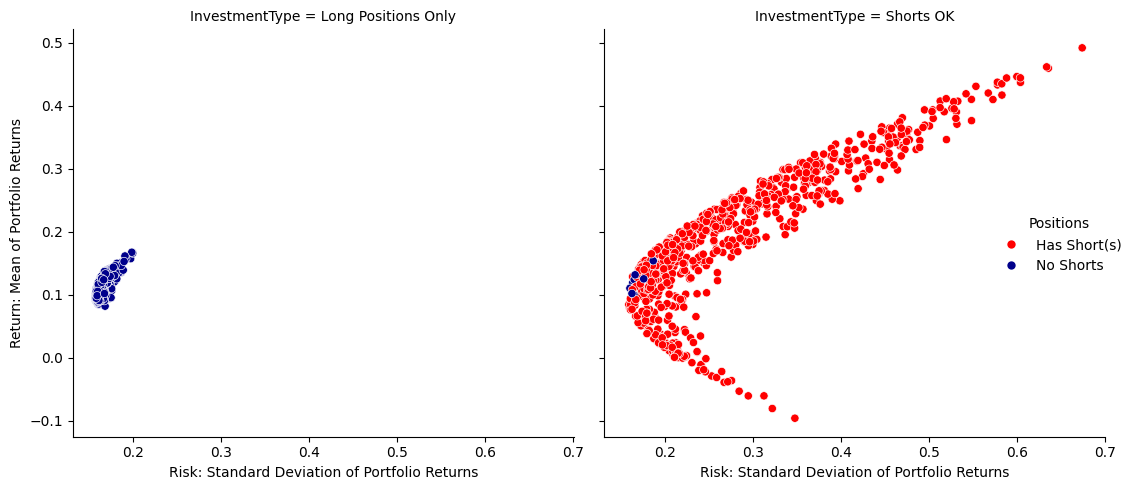

In [24]:
# Combine for plotting
plotting_frame_set_2 = pd.concat([shorts_allowed_results_set_2, no_shorts_results_set_2], ignore_index=True)
plotting_frame_set_2["Positions"] = plotting_frame_set_2["Positions"].map({1: "Has Short(s)", 2: "No Shorts"})
plotting_frame_set_2["InvestmentType"] = plotting_frame_set_2["InvestmentType"].astype("category")

set_2_plot = sns.relplot(
    data=plotting_frame_set_2,
    x="returnSD",
    y="returnMean",
    hue="Positions",
    col="InvestmentType",
    palette={
        "Has Short(s)": "red",
        "No Shorts": "darkblue"
    }
)
set_2_plot.set_axis_labels("Risk: Standard Deviation of Portfolio Returns", "Return: Mean of Portfolio Returns")
plt.tight_layout()

# Save to PDF
pdf_path = "monte_carlo_results_set_2.pdf"
with PdfPages(pdf_path) as pdf:
    pdf.savefig(set_2_plot.figure)

print("Saved `Set 2` plot to", pdf_path)